# CS 440/540: Deep Learning: Computational Structures and Programming Assignment 2

## Set up Datasets (training/test)

In [26]:
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

## Image Examples

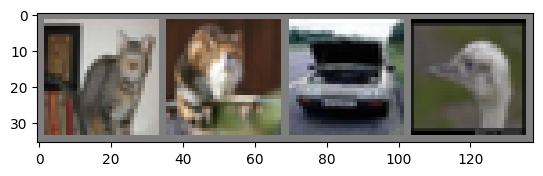

cat   cat   car   bird 


In [19]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

## Set up CNN w/LeNet Architecture

In [20]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class CNet(nn.Module):
    def __init__(self, activation="relu"):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5, stride=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

        if activation == "relu":
            self.act = F.sigmoid
        elif activation == "tanh":
            self.act = F.tanh
        else:
            raise ValueError("Activation must be `relu` or `tanh`")
        
    def forward(self, x):
        x = self.pool(self.act(self.conv1(x)))
        x = self.pool(self.act(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        x = self.fc3(x)
        return x

lrs = [0.1, 0.01, 0.001]
activations = ["sigmoid", "tanh"]
losses = [nn.CrossEntropyLoss(), nn.MSELoss()]

## Test all 12 Cases

In [22]:
import torch.optim as optim
import torch.nn.functional as F

lrs = [0.1, 0.01, 0.001]
activations = ["sigmoid", "tanh"]
loss_fns = {
    "ce": nn.CrossEntropyLoss(),
    "mse": nn.MSELoss()
}

def one_hot(labels, num_classes=10):
    return F.one_hot(labels, num_classes).float()

def run_experiment(lr, activation, loss_name, epochs=20, device="cpu"):
    net = CNet(activation=activation).to(device)
    optimizer = optim.SGD(net.parameters(), lr=lr)

    train_losses = []
    test_losses = []

    criterion = loss_fns[loss_name]

    for epoch in range(epochs):
        # ---- TRAIN ----
        net.train()
        running_train_loss = 0.0

        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = net(inputs)

            if loss_name == "mse":
                labels_oh = one_hot(labels).to(device)
                loss = criterion(outputs, labels_oh)
            else:
                loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()

        avg_train_loss = running_train_loss / len(trainloader)
        train_losses.append(avg_train_loss)

        # ---- TEST ----
        net.eval()
        running_test_loss = 0.0
        correct, total = 0, 0

        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = net(inputs)

                if loss_name == "mse":
                    labels_oh = one_hot(labels).to(device)
                    loss = criterion(outputs, labels_oh)
                else:
                    loss = criterion(outputs, labels)

                running_test_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        avg_test_loss = running_test_loss / len(testloader)
        acc = 100 * correct / total
        test_losses.append(avg_test_loss)

        print(f"[lr={lr}, act={activation}, loss={loss_name}] "
              f"Epoch {epoch+1}: Train Loss={avg_train_loss:.4f}, "
              f"Test Loss={avg_test_loss:.4f}, Acc={acc:.2f}%")

    return train_losses, test_losses


In [5]:
results = {}

for lr in lrs:
    for activation in activations:
        for loss_name in ["ce", "mse"]:
            key = f"lr={lr}_act={activation}_loss={loss_name}"
            print("\nRunning:", key)
            train_curve, test_curve = run_experiment(lr, activation, loss_name, epochs=20)
            results[key] = {
                "train": train_curve,
                "test": test_curve
            }



Running: lr=0.1_act=sigmoid_loss=ce
[lr=0.1, act=sigmoid, loss=ce] Epoch 1: Train Loss=2.3109, Test Loss=2.3077, Acc=10.00%
[lr=0.1, act=sigmoid, loss=ce] Epoch 2: Train Loss=2.3032, Test Loss=2.1930, Acc=18.63%
[lr=0.1, act=sigmoid, loss=ce] Epoch 3: Train Loss=1.9850, Test Loss=1.7817, Acc=32.92%
[lr=0.1, act=sigmoid, loss=ce] Epoch 4: Train Loss=1.6565, Test Loss=1.5180, Acc=43.43%
[lr=0.1, act=sigmoid, loss=ce] Epoch 5: Train Loss=1.4331, Test Loss=1.3577, Acc=49.40%
[lr=0.1, act=sigmoid, loss=ce] Epoch 6: Train Loss=1.3134, Test Loss=1.2772, Acc=53.79%
[lr=0.1, act=sigmoid, loss=ce] Epoch 7: Train Loss=1.2289, Test Loss=1.2279, Acc=55.66%
[lr=0.1, act=sigmoid, loss=ce] Epoch 8: Train Loss=1.1699, Test Loss=1.2462, Acc=56.47%
[lr=0.1, act=sigmoid, loss=ce] Epoch 9: Train Loss=1.1211, Test Loss=1.1945, Acc=57.42%
[lr=0.1, act=sigmoid, loss=ce] Epoch 10: Train Loss=1.0779, Test Loss=1.1303, Acc=59.88%
[lr=0.1, act=sigmoid, loss=ce] Epoch 11: Train Loss=1.0394, Test Loss=1.0923, Acc=

# Plot

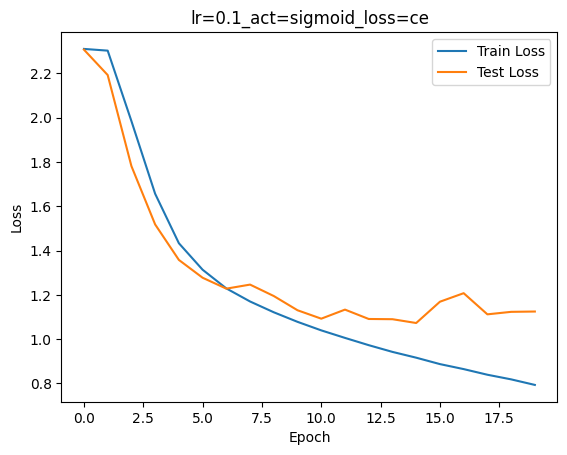

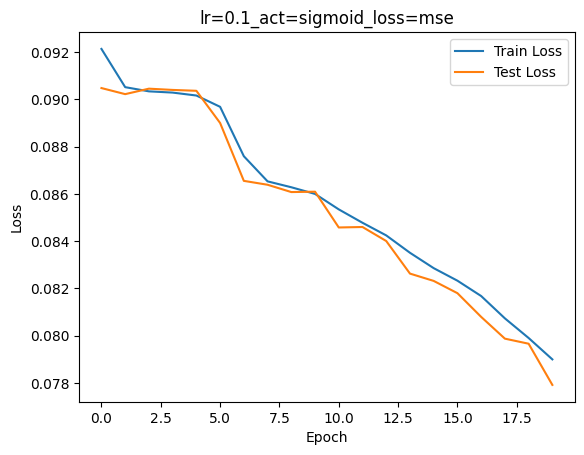

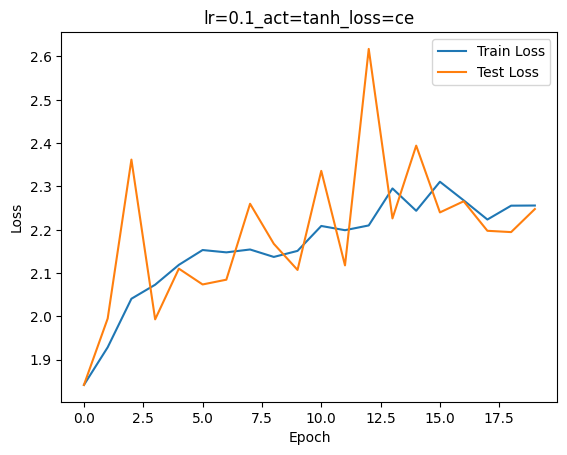

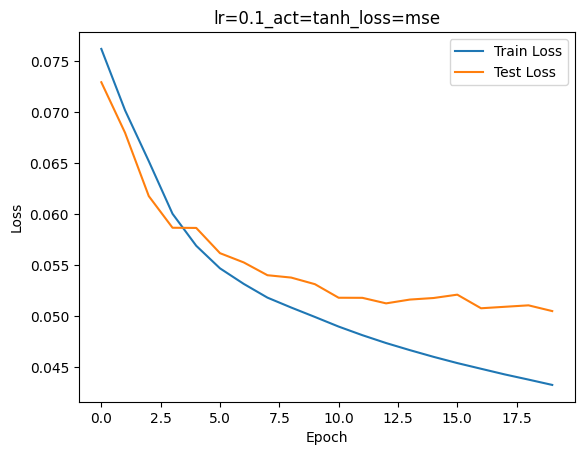

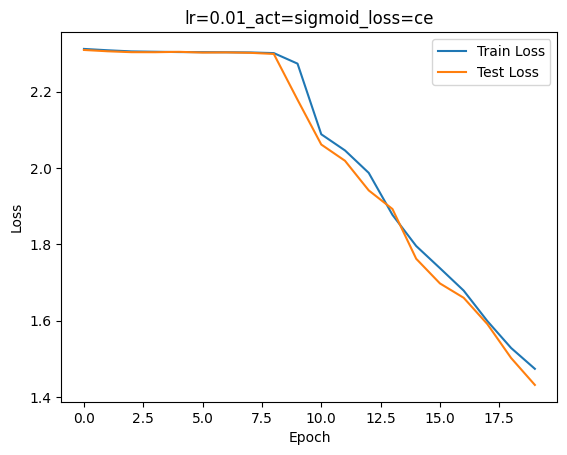

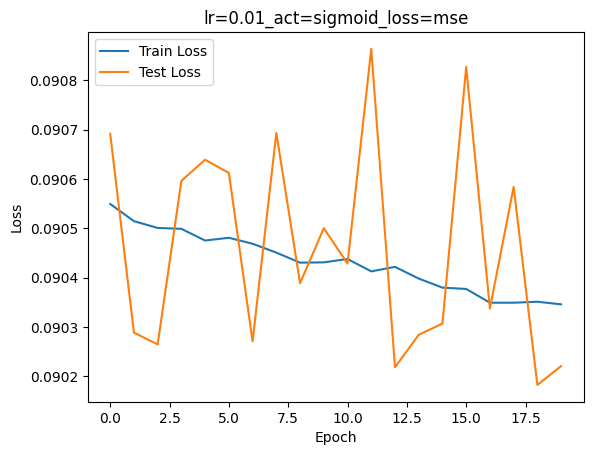

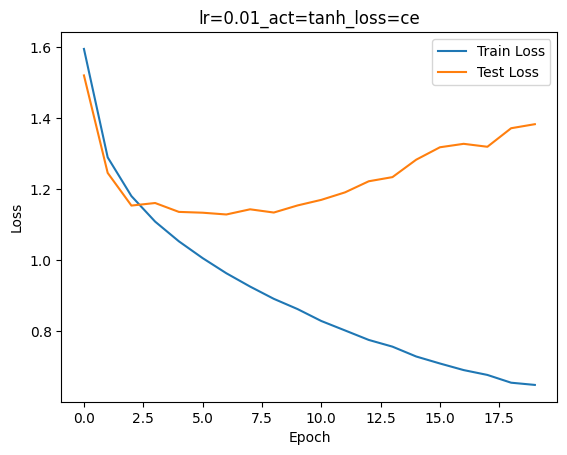

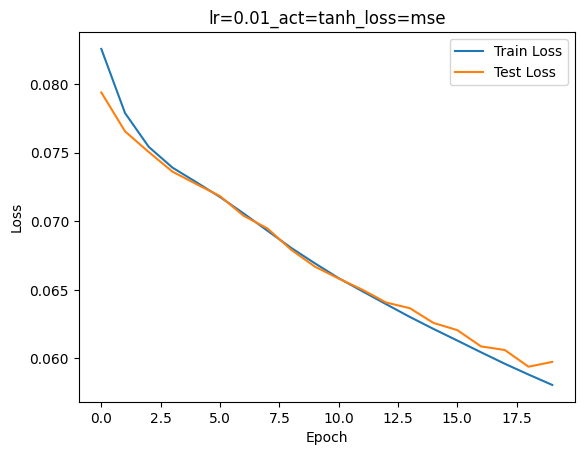

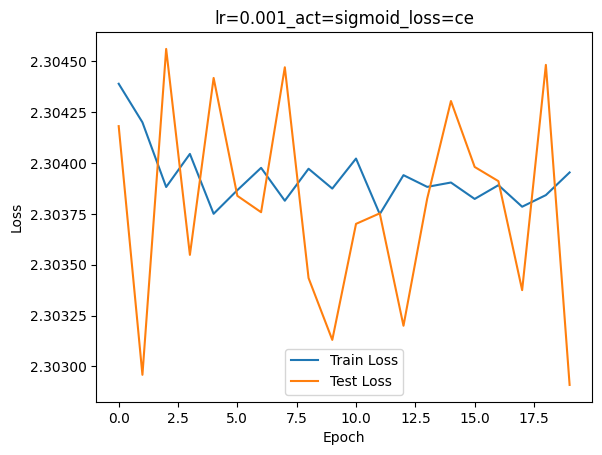

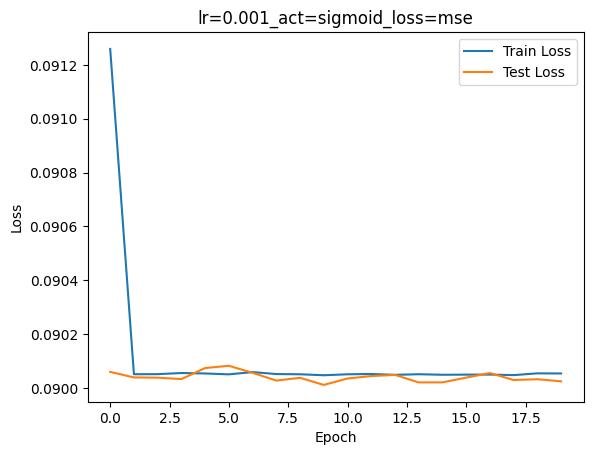

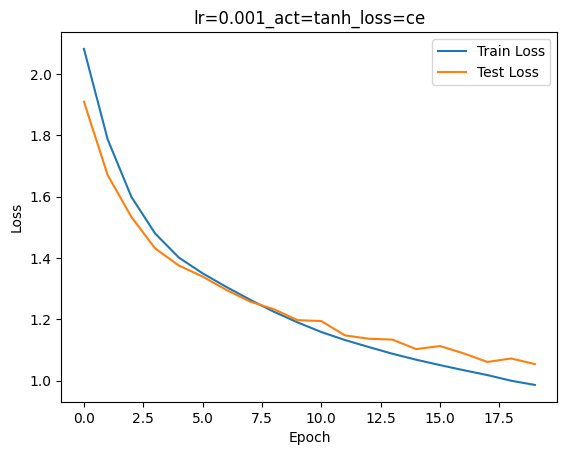

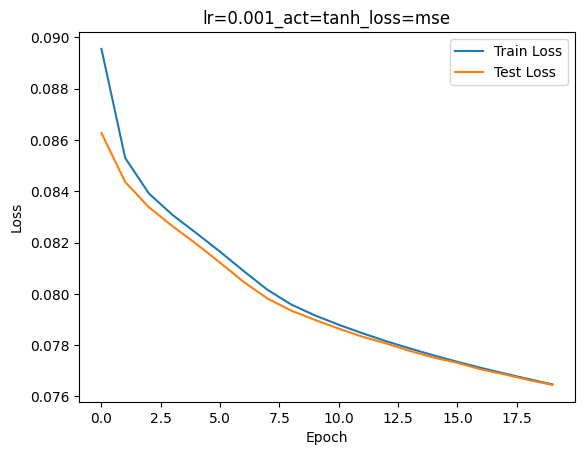

In [6]:
import matplotlib.pyplot as plt

for k, v in results.items():
    plt.figure()
    plt.plot(v["train"], label="Train Loss")
    plt.plot(v["test"], label="Test Loss")
    plt.title(k)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


In [ ]:
def visualize_feature_maps(net, images):
    net.eval()
    with torch.no_grad():
        x = net.pool(net.act(net.conv1(images)))
        x = net.pool(net.act(net.conv2(x)))  # last conv layer output

    feature_maps = x[0]  # take first image
    fig, axes = plt.subplots(4, 4, figsize=(8, 8))

    for i, ax in enumerate(axes.flat):
        ax.imshow(feature_maps[i].cpu(), cmap="gray")
        ax.axis("off")

    plt.suptitle("Feature Maps from Last Conv Layer")
    plt.show()



# Section 2

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNet2(nn.Module):
    def __init__(self, activation="relu"):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, stride=1)   # 32x32 -> 30x30
        self.pool = nn.MaxPool2d(2, 2)              # 30x30 -> 15x15
        self.conv2 = nn.Conv2d(6, 16, 3)            # 15x15 -> 13x13
                                                      # pool -> 6x6
        self.fc1 = nn.Linear(16 * 6 * 6, 120)       # Adjusted input size
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

        if activation == "sigmoid":
            self.act = torch.sigmoid
        elif activation == "tanh":
            self.act = torch.tanh
        elif activation == "relu":
            self.act = torch.relu
        else:
            raise ValueError("Activation must be `sigmoid` or `tanh`")

    def forward(self, x):
        x = self.pool(self.act(self.conv1(x)))
        x = self.pool(self.act(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        x = self.fc3(x)  # logits (for CE)
        return x


In [18]:
def one_hot(labels, num_classes=10):
    return F.one_hot(labels, num_classes).float()

def run_experiment(lr, activation, loss_name, epochs=20, device="cpu"):
    net = CNet2(activation=activation).to(device)
    optimizer = optim.SGD(net.parameters(), lr=lr)

    train_losses = []
    test_losses = []

    criterion = loss_fns[loss_name]

    for epoch in range(epochs):
        # ---- TRAIN ----
        net.train()
        running_train_loss = 0.0

        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = net(inputs)

            if loss_name == "mse":
                labels_oh = one_hot(labels).to(device)
                loss = criterion(outputs, labels_oh)
            else:
                loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()

        avg_train_loss = running_train_loss / len(trainloader)
        train_losses.append(avg_train_loss)

        # ---- TEST ----
        net.eval()
        running_test_loss = 0.0
        correct, total = 0, 0

        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = net(inputs)

                if loss_name == "mse":
                    labels_oh = one_hot(labels).to(device)
                    loss = criterion(outputs, labels_oh)
                else:
                    loss = criterion(outputs, labels)

                running_test_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        avg_test_loss = running_test_loss / len(testloader)
        acc = 100 * correct / total
        test_losses.append(avg_test_loss)

        print(f"[lr={lr}, act={activation}, loss={loss_name}] "
              f"Epoch {epoch+1}: Train Loss={avg_train_loss:.4f}, "
              f"Test Loss={avg_test_loss:.4f}, Acc={acc:.2f}%")

    return train_losses, test_losses

[lr=0.001, act=relu, loss=ce] Epoch 1: Train Loss=2.2910, Test Loss=2.2309, Acc=16.24%
[lr=0.001, act=relu, loss=ce] Epoch 2: Train Loss=2.0221, Test Loss=1.8468, Acc=31.45%
[lr=0.001, act=relu, loss=ce] Epoch 3: Train Loss=1.7285, Test Loss=1.6035, Acc=40.60%
[lr=0.001, act=relu, loss=ce] Epoch 4: Train Loss=1.5529, Test Loss=1.4856, Acc=46.04%
[lr=0.001, act=relu, loss=ce] Epoch 5: Train Loss=1.4506, Test Loss=1.4366, Acc=47.98%
[lr=0.001, act=relu, loss=ce] Epoch 6: Train Loss=1.3819, Test Loss=1.3301, Acc=52.01%
[lr=0.001, act=relu, loss=ce] Epoch 7: Train Loss=1.3240, Test Loss=1.3102, Acc=52.91%
[lr=0.001, act=relu, loss=ce] Epoch 8: Train Loss=1.2736, Test Loss=1.2697, Acc=54.67%
[lr=0.001, act=relu, loss=ce] Epoch 9: Train Loss=1.2288, Test Loss=1.2338, Acc=56.59%
[lr=0.001, act=relu, loss=ce] Epoch 10: Train Loss=1.1898, Test Loss=1.2221, Acc=56.41%
[lr=0.001, act=relu, loss=ce] Epoch 11: Train Loss=1.1530, Test Loss=1.1741, Acc=58.64%
[lr=0.001, act=relu, loss=ce] Epoch 12: T

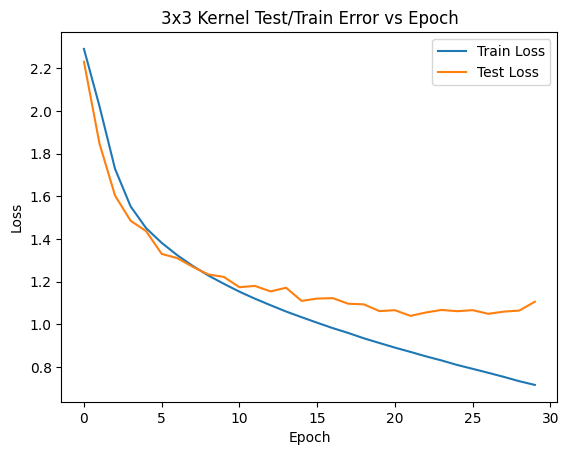

In [20]:
lr = 0.001
activation = "relu"
loss_name = "ce"
train_curve, test_curve = run_experiment(lr, activation, loss_name, epochs=30)


plt.figure()
plt.plot(train_curve, label="Train Loss")
plt.plot(test_curve, label="Test Loss")
plt.title("3x3 Kernel Test/Train Error vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Section 3

## Set up Data

In [24]:
import yfinance as yf
import pandas as pd

# Download Dow Jones Industrial Average
df = yf.download("^DJI", start="2000-01-01", end="2025-01-01")

# save to CSV
df.to_csv("dow_jones.csv")

print(df.head())

df = pd.read_csv("dow_jones.csv")

# handle missing data
high_prices = pd.to_numeric(df["High"], errors="coerce")
high_prices = high_prices.dropna().values.astype("float32")

high_prices

[*********************100%***********************]  1 of 1 completed

Price              Close          High           Low          Open     Volume
Ticker              ^DJI          ^DJI          ^DJI          ^DJI       ^DJI
Date                                                                         
2000-01-03  11357.509766  11522.009766  11305.690430  11501.849609  169750000
2000-01-04  10997.929688  11350.059570  10986.450195  11349.750000  178420000
2000-01-05  11122.650391  11215.099609  10938.669922  10989.370117  203190000
2000-01-06  11253.259766  11313.450195  11098.450195  11113.370117  176550000
2000-01-07  11522.559570  11528.139648  11239.919922  11247.059570  184900000


array([11522.01, 11350.06, 11215.1 , ..., 43238.85, 42863.86, 42779.69],
      dtype=float32)

## Normalize and Split Data

In [36]:
import numpy as np 
from torch.utils.data import TensorDataset, DataLoader

mean = high_prices.mean()
std = high_prices.std()
high_prices_norm = (high_prices - mean) / std

def make_sequences(data, window_size=100):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

X, y = make_sequences(high_prices_norm, window_size=100)


print(X.shape, y.shape)
n = len(X)
train_end = int(0.7 * n)
val_end = int(0.85 * n)

X_train, y_train = X[:train_end], y[:train_end]
X_val, y_val = X[train_end:val_end], y[train_end:val_end]
X_test, y_test = X[val_end:], y[val_end:]

#convert to tensors

X_train_t = torch.tensor(X_train).unsqueeze(-1).float()
y_train_t = torch.tensor(y_train).unsqueeze(-1).float()

X_val_t = torch.tensor(X_val).unsqueeze(-1).float()
y_val_t = torch.tensor(y_val).unsqueeze(-1).float()

X_test_t = torch.tensor(X_test).unsqueeze(-1).float()
y_test_t = torch.tensor(y_test).unsqueeze(-1).float()

train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=64, shuffle=True)
val_loader   = DataLoader(TensorDataset(X_val_t, y_val_t), batch_size=64, shuffle=False)
test_loader  = DataLoader(TensorDataset(X_test_t, y_test_t), batch_size=64, shuffle=False)

(6189, 100) (6189,)


## Create RNN

In [25]:
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])  # Take the output of the last time step
        return out

input_size = 1
hidden_size = 50
output_size = 1

model = RNNModel(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


## Train, Tests, and Validate Model

In [37]:
device = "cpu"  # or cuda
model = RNNModel(input_size=1, hidden_size=50, output_size=1).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 30
train_losses, val_losses, test_losses = [], [], []

for epoch in range(epochs):
    # ---- train ----
    model.train()
    running_train = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)

        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        running_train += loss.item() * xb.size(0)

    epoch_train_loss = running_train / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    # ---- validation ----
    model.eval()
    running_val = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            running_val += loss.item() * xb.size(0)

    epoch_val_loss = running_val / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)

    # ---- test (optional each epoch; or do once at end) ----
    running_test = 0.0
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            running_test += loss.item() * xb.size(0)

    epoch_test_loss = running_test / len(test_loader.dataset)
    test_losses.append(epoch_test_loss)

    print(f"Epoch {epoch+1:02d}/{epochs} | "
          f"Train: {epoch_train_loss:.6f} | "
          f"Val: {epoch_val_loss:.6f} | "
          f"Test: {epoch_test_loss:.6f}")


Epoch 01/30 | Train: 0.066580 | Val: 0.037432 | Test: 0.358789
Epoch 02/30 | Train: 0.000408 | Val: 0.015553 | Test: 0.257099
Epoch 03/30 | Train: 0.000334 | Val: 0.013754 | Test: 0.234850
Epoch 04/30 | Train: 0.000319 | Val: 0.013219 | Test: 0.220017
Epoch 05/30 | Train: 0.000300 | Val: 0.012415 | Test: 0.204950
Epoch 06/30 | Train: 0.000292 | Val: 0.013264 | Test: 0.199048
Epoch 07/30 | Train: 0.000273 | Val: 0.011178 | Test: 0.179548
Epoch 08/30 | Train: 0.000268 | Val: 0.011404 | Test: 0.175163
Epoch 09/30 | Train: 0.000266 | Val: 0.011148 | Test: 0.166103
Epoch 10/30 | Train: 0.000281 | Val: 0.010700 | Test: 0.160291
Epoch 11/30 | Train: 0.000268 | Val: 0.010023 | Test: 0.151068
Epoch 12/30 | Train: 0.000257 | Val: 0.009562 | Test: 0.145991
Epoch 13/30 | Train: 0.000284 | Val: 0.008310 | Test: 0.134169
Epoch 14/30 | Train: 0.000274 | Val: 0.008151 | Test: 0.130348
Epoch 15/30 | Train: 0.000253 | Val: 0.007779 | Test: 0.123403
Epoch 16/30 | Train: 0.000250 | Val: 0.007886 | Test: 0

## Plot

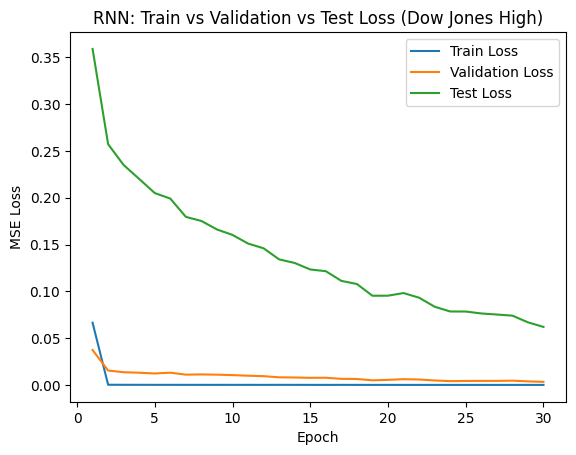

In [38]:
plt.plot(range(1, epochs + 1), train_losses, label="Train Loss")
plt.plot(range(1, epochs + 1), val_losses, label="Validation Loss")
plt.plot(range(1, epochs + 1), test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("RNN: Train vs Validation vs Test Loss (Dow Jones High)")
plt.legend()
plt.show()


# Section 3b

In [44]:
from scipy.fft import fft, fftfreq
file = "seattle-weather.csv"

sea_weather_df = pd.read_csv(file, parse_dates=['date'])
sea_weather_df = sea_weather_df.sort_values('date')
sea_weather_df.info()

max_temp = sea_weather_df['temp_max'].values

one_year_temp = max_temp[:365]
fft_1year = fft(one_year_temp)
freqs_1year = fftfreq(len(one_year_temp), d=1)

magnitude_1year = np.abs(fft_1year)

positive_freqs_1year = freqs_1year[:len(freqs_1year)//2]
positive_magnitude_1year = magnitude_1year[:len(magnitude_1year)//2]

three_year_temp = max_temp[:1095]

fft_3year = fft(three_year_temp)
freqs_3year = fftfreq(len(three_year_temp), d=1)

magnitude_3year = np.abs(fft_3year)

positive_freqs_3year = freqs_3year[:len(freqs_3year)//2]
positive_magnitudes_3year = magnitude_3year[:len(magnitude_3year)//2]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           1461 non-null   datetime64[ns]
 1   precipitation  1461 non-null   float64       
 2   temp_max       1461 non-null   float64       
 3   temp_min       1461 non-null   float64       
 4   wind           1461 non-null   float64       
 5   weather        1461 non-null   object        
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 68.6+ KB


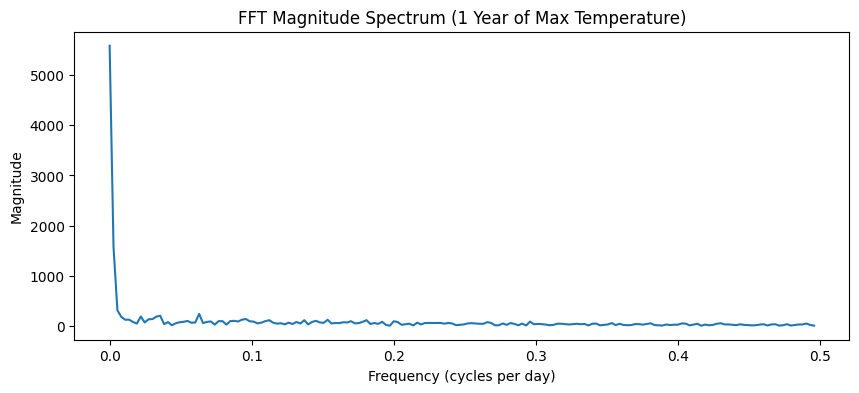

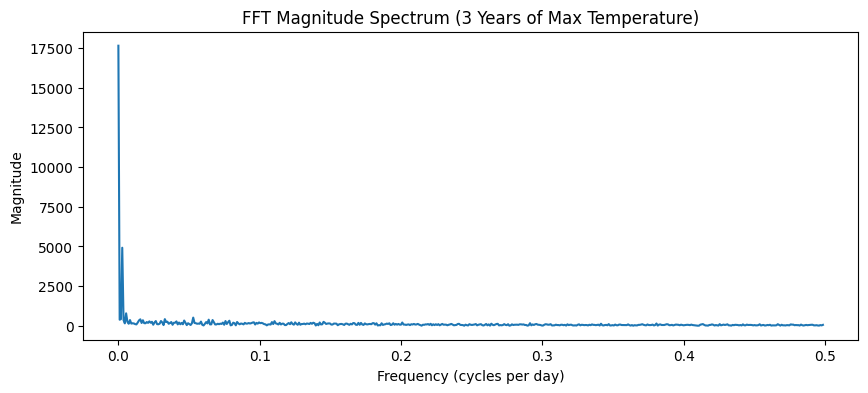

In [45]:
plt.figure(figsize=(10, 4))
plt.plot(positive_freqs_1year, positive_magnitude_1year)
plt.title("FFT Magnitude Spectrum (1 Year of Max Temperature)")
plt.xlabel("Frequency (cycles per day)")
plt.ylabel("Magnitude")
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(positive_freqs_3year, positive_magnitudes_3year)
plt.title("FFT Magnitude Spectrum (3 Years of Max Temperature)")
plt.xlabel("Frequency (cycles per day)")
plt.ylabel("Magnitude")
plt.show()

In [47]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# --- Use exactly 3 years (365*3) ---
days_per_year = 365
series = max_temp[:days_per_year * 3].astype(np.float32)

train_series = series[:days_per_year * 2]      # years 1-2
test_series  = series[days_per_year * 2:]      # year 3 (365 days)

# --- Normalize using TRAIN stats only (important: no leakage) ---
train_mean = train_series.mean()
train_std = train_series.std()

train_norm = (train_series - train_mean) / train_std
test_norm  = (test_series  - train_mean) / train_std


In [48]:
def make_windows(data, lookback=30):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i+lookback])
        y.append(data[i+lookback])
    return np.array(X), np.array(y)

lookback = 30
X_train, y_train = make_windows(train_norm, lookback=lookback)

X_train_t = torch.tensor(X_train).unsqueeze(-1).float()  # [N, lookback, 1]
y_train_t = torch.tensor(y_train).unsqueeze(-1).float()  # [N, 1]

train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=64, shuffle=True)


## Train model on three years of data

Epoch 01/30 | Train Loss: 0.817671
Epoch 02/30 | Train Loss: 0.372534
Epoch 03/30 | Train Loss: 0.240332
Epoch 04/30 | Train Loss: 0.203884
Epoch 05/30 | Train Loss: 0.191127
Epoch 06/30 | Train Loss: 0.183342
Epoch 07/30 | Train Loss: 0.179701
Epoch 08/30 | Train Loss: 0.172803
Epoch 09/30 | Train Loss: 0.167964
Epoch 10/30 | Train Loss: 0.162679
Epoch 11/30 | Train Loss: 0.159045
Epoch 12/30 | Train Loss: 0.155155
Epoch 13/30 | Train Loss: 0.152383
Epoch 14/30 | Train Loss: 0.150283
Epoch 15/30 | Train Loss: 0.146568
Epoch 16/30 | Train Loss: 0.144060
Epoch 17/30 | Train Loss: 0.141541
Epoch 18/30 | Train Loss: 0.139918
Epoch 19/30 | Train Loss: 0.139878
Epoch 20/30 | Train Loss: 0.139875
Epoch 21/30 | Train Loss: 0.137815
Epoch 22/30 | Train Loss: 0.135212
Epoch 23/30 | Train Loss: 0.135947
Epoch 24/30 | Train Loss: 0.134563
Epoch 25/30 | Train Loss: 0.133896
Epoch 26/30 | Train Loss: 0.132952
Epoch 27/30 | Train Loss: 0.131997
Epoch 28/30 | Train Loss: 0.131832
Epoch 29/30 | Train 

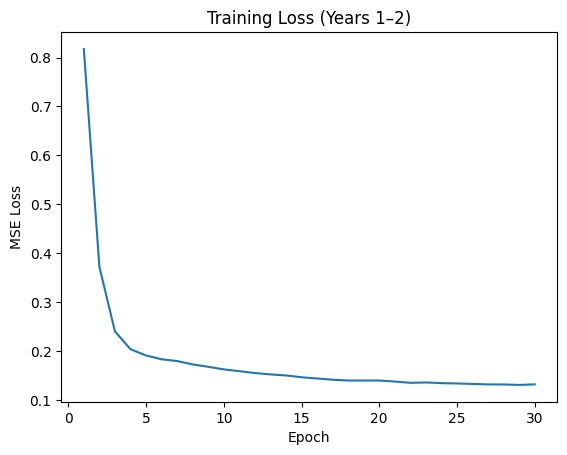

In [49]:
device = "cpu"
model = RNNModel(input_size=1, hidden_size=50, output_size=1).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 30
train_losses = []

for epoch in range(epochs):
    model.train()
    running = 0.0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)

        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()

        # helps stability with vanilla RNN
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        running += loss.item() * xb.size(0)

    epoch_loss = running / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    print(f"Epoch {epoch+1:02d}/{epochs} | Train Loss: {epoch_loss:.6f}")

plt.plot(range(1, epochs+1), train_losses)
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training Loss (Years 1–2)")
plt.show()


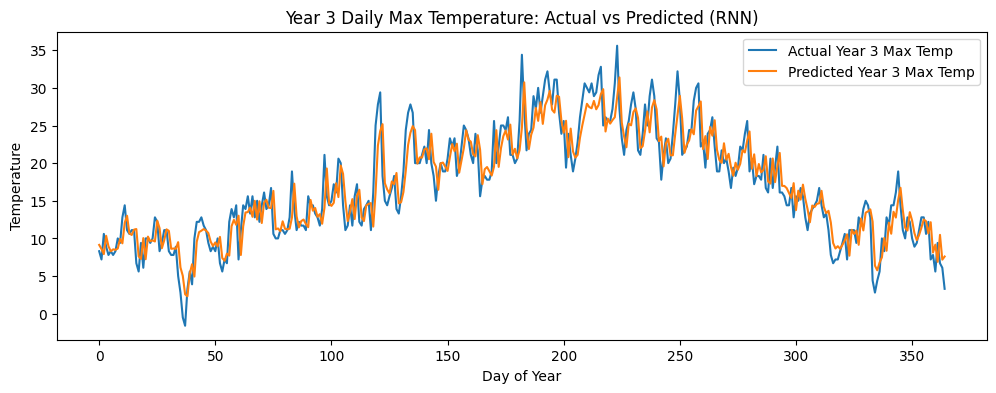

In [51]:
model.eval()

full_norm = np.concatenate([train_norm, test_norm])  # years 1-3 normalized
start_idx = days_per_year * 2  # start of year 3 in full_norm

preds_norm = []

with torch.no_grad():
    for t in range(start_idx, start_idx + days_per_year):
        window = full_norm[t - lookback:t]  # true history
        xb = torch.tensor(window).view(1, lookback, 1).float().to(device)
        yhat = model(xb).item()
        preds_norm.append(yhat)

preds = np.array(preds_norm) * train_std + train_mean
actual = test_series

plt.figure(figsize=(12, 4))
plt.plot(actual, label="Actual Year 3 Max Temp")
plt.plot(preds, label="Predicted Year 3 Max Temp")
plt.title("Year 3 Daily Max Temperature: Actual vs Predicted (RNN)")
plt.xlabel("Day of Year")
plt.ylabel("Temperature")
plt.legend()
plt.show()
